In [157]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,QuantileTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
full_name = 'Dmitry Polovnikov'
random_state = sum(map(ord,full_name))

In [159]:
MDATA_PATH = 'sirius_ml_labs-main-ps4-mdata/ps4/mdata'

In [160]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

def get_market_data(ticker):
    data = []
    for date in dates:
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [161]:
ticker = 'Z.DOGE'

In [162]:
mdata,pgrid,vgrid = get_market_data(ticker)
ix = (mdata['HIGH']<=1.1*mdata['VWAP'])&(mdata['LOW']>=0.9*mdata['VWAP'])
mdata,pgrid,vgrid = mdata[ix],pgrid[ix],vgrid[ix]
#mdata = mdata.groupby(mdata.index).last()

/tmp/ipykernel_2854990/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2854990/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2854990/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_2854990/2711608588.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then 

In [163]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

<Axes: >

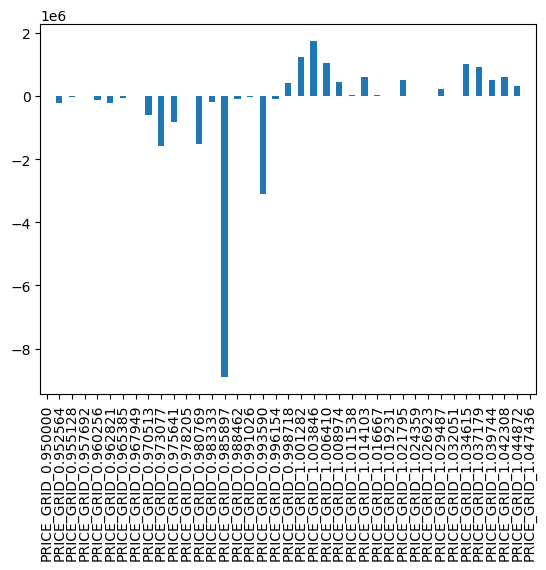

In [164]:
pgrid.iloc[0].plot(kind='bar')

<Axes: >

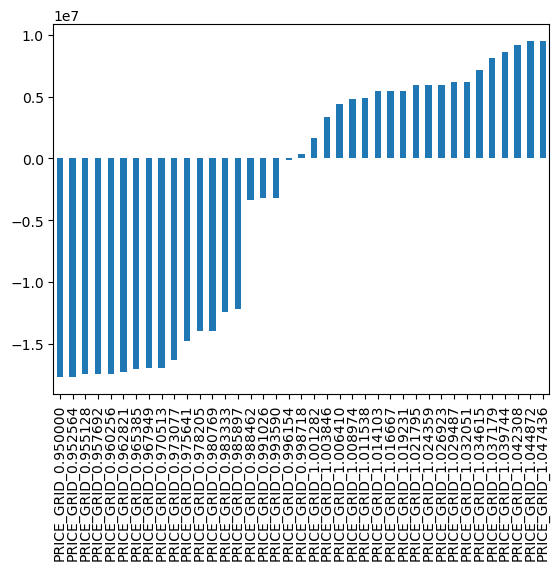

In [165]:
pd.concat([pgrid.iloc[0].iloc[:19][::-1].cumsum()[::-1],pgrid.iloc[0].iloc[19:].cumsum()]).plot(kind='bar')

In [166]:
# transform data to convolution-compatible format such that it has dimension=3 and second dimension corresponds to the channels number (1)
DEVICE = 'cpu'
P_t = torch.tensor(pgrid.values,dtype=torch.float32,device=DEVICE)[:,None,:]

In [167]:
P_t.shape

torch.Size([458332, 1, 39])

In [168]:
l1 = nn.Conv1d(in_channels=1,out_channels=5,kernel_size=5,stride=1)

In [169]:
l1(P_t).shape

torch.Size([458332, 5, 35])

In [170]:
"""
Please implement (at the latest stage) here the following neural network

                  => Linear[features:33->hid_size1] => ReLU => 
                  => Linear[features:hid_size1->hid_size2] => ReLU =>
                  => Linear[features:hid_size2->1] => ReLU
                /                                                            \
Features (33,39)                                                              => ReLU => Linear[features:10->1]
                \                                                            /
                  => Convolution[channels:1->5,kernel=5,stride=2] => ReLU =>
                  => Convolution[channels:5->5,kernel=5,stride=2] => ReLU =>
                  => Convolution[channels:5->5,kernel=4,stride=1] => ReLU =>
                  => Flatten on {1,2} => Linear[25->9] => ReLU

Please use the following interfaces

nn.Linear - for linear transform
nn.Conv1d - for convolution
nn.Flatten - for flattening
nn.ReLU - for ReLU
torch.concat - to concatenate tensors (before final ReLU and linear transform)

Plase use nn.Sequential to group sequentially following transforms (for example, 6 transforms in the upper figure and 9 transforms in the lower figure )

"""

'\nPlease implement (at the latest stage) here the following neural network\n\n                  => Linear[features:33->hid_size1] => ReLU => \n                  => Linear[features:hid_size1->hid_size2] => ReLU =>\n                  => Linear[features:hid_size2->1] => ReLU\n                /                                                            Features (33,39)                                                              => ReLU => Linear[features:10->1]\n                \\                                                            /\n                  => Convolution[channels:1->5,kernel=5,stride=2] => ReLU =>\n                  => Convolution[channels:5->5,kernel=5,stride=2] => ReLU =>\n                  => Convolution[channels:5->5,kernel=4,stride=1] => ReLU =>\n                  => Flatten on {1,2} => Linear[25->9] => ReLU\n\nPlease use the following interfaces\n\nnn.Linear - for linear transform\nnn.Conv1d - for convolution\nnn.Flatten - for flattening\nnn.ReLU - for ReLU\ntor

In [384]:
"""
Convolution[channels:1->3,kernel=5,stride=1] => ReLU =>
=> Convolution[channels:2->3,kernel=4,stride=1] => ReLU =>
=> Convolution[channels:3->4,kernel=3,stride=1] => ReLU =>
AvgPool
"""

# assumed input_size = 39
class MMFCNNTrain(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=2,kernel_size=12,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=2,out_channels=3,kernel_size=11,stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=3,out_channels=4,kernel_size=9,stride=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1,end_dim=2),
            nn.Linear(in_features=4,out_features=1),
            nn.ReLU()
        )
        self.network2 = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=2,kernel_size=10,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=2,out_channels=3,kernel_size=6,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=3,out_channels=4,kernel_size=2,stride=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1,end_dim=2),
            nn.Linear(in_features=12,out_features=1),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.ReLU()
        )
        
    def forward(self,x):
        out1 = self.network.forward(x['p'])
        out2 = self.network2.forward(x['v'])
        out = self.output(out1 + out2)
        
        return out

In [385]:
features_dict['p'].shape, features_dict['v'].shape

(torch.Size([293332, 1, 39]), torch.Size([293332, 1, 18]))

In [386]:
mmf_cnn_train = MMFCNNTrain()
mmf_cnn_train(features_dict).shape

torch.Size([293332, 1])

#### TRAIN\VAL\TEST | TRANSFORM

In [219]:
data_index = pgrid.index[int(pgrid.index.shape[0] * 0.8)]

X_train, X_test = pgrid[:data_index], pgrid[data_index:]
X_train_v, X_test_v = vgrid[:data_index], vgrid[data_index:]

y_train, y_test = returns_ahead[:data_index], returns_ahead[data_index:]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
X_train_v, X_val_v, _, _ = train_test_split(X_train_v, X_train_v, test_size=0.2, random_state=random_state)

y_train, y_val, y_test = np.array(y_train).reshape(-1,1), np.array(y_val).reshape(-1,1), np.array(y_test).reshape(-1,1)

In [221]:
Qt_x = QuantileTransformer(output_distribution='normal')
Qt_x.fit(X_train)

Qt_xv = QuantileTransformer(output_distribution='normal')
Qt_xv.fit(X_train_v)

Qt_y = QuantileTransformer(output_distribution='normal')
Qt_y.fit(y_train)

X_train, X_val, X_test = Qt_x.transform(X_train), Qt_x.transform(X_val), Qt_x.transform(X_test)
X_train_v, X_val_v, X_test_v = Qt_xv.transform(X_train_v), Qt_xv.transform(X_val_v), Qt_xv.transform(X_test_v)

y_train, y_val, y_test = Qt_y.transform(y_train), Qt_y.transform(y_val), Qt_y.transform(y_test)

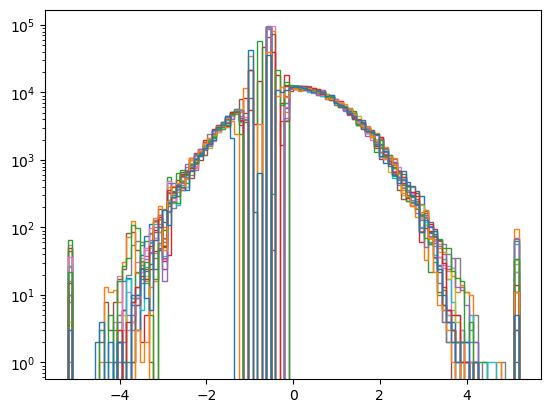

In [222]:
_ = plt.hist(
        X_train_v,
        histtype='step',
        bins=100,
        log=True
    )

In [223]:
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
X_val_t = torch.tensor(X_val, dtype=torch.float32, device=DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)

X_train_tv = torch.tensor(X_train_v, dtype=torch.float32, device=DEVICE)
X_val_tv = torch.tensor(X_val_v, dtype=torch.float32, device=DEVICE)
X_test_tv = torch.tensor(X_test_v, dtype=torch.float32, device=DEVICE)

y_train_t = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.float32, device=DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

#### FIT mmf_cnn_train, 

In [224]:
# MMF - market microstructure features
MMFEpisode = namedtuple('MMFEpisode',['features','targets'])

In [367]:
features_dict = {'p': X_train_t, 'v': X_train_tv}
features_dict_val = {'p': X_val_t, 'v': X_val_tv}

In [240]:
class MMFSet(torch.utils.data.Dataset):
    def __init__(self, X, y, episode_len):
        super().__init__()
        
        assert X['p'].shape[0] == y.shape[0]
        
        self.n_ticks, self.n_features = X['p'].shape
        self.episode_len = episode_len
        self.features_t = X['p'][:,None,:]
        self.features_tv = X['v'][:,None,:]
        self.targets_t = y
    
    def __len__(self):
        return self.n_ticks-self.episode_len+1
    
    def __getitem__(self,i):
        return MMFEpisode(
            features = {'p': self.features_t[i], 'v': self.features_tv[i]},
            targets = self.targets_t[i]
        )

In [241]:
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPISODE_LEN = 128

In [242]:
pgrid.values.shape

(458332, 39)

In [243]:
mmf_train_set = MMFSet(features_dict, y_train_t, EPISODE_LEN)

In [186]:
mmf_train_set = MMFSet(X_train_t, y_train_t, EPISODE_LEN)

torch.Size([293332, 39])


In [250]:
mmf_cnn = MMFCNNTrain()

mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_cnn.parameters(),lr=LEARNING_RATE)

In [251]:
mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )

In [252]:
mmf_episode

MMFEpisode(features=tensor([[[-0.5818, -0.4174, -0.3160,  ...,  0.3558, -0.1332,  0.1954]],

        [[-0.5667, -2.1420, -0.3484,  ..., -0.2739,  0.1983, -1.2688]],

        [[-0.8600, -1.8274, -0.4937,  ...,  0.2091,  0.6035,  1.4355]],

        ...,

        [[-2.5370, -0.4401, -1.8952,  ...,  1.3275,  1.4094,  1.3264]],

        [[-0.3760,  0.0405, -0.5230,  ..., -0.0883,  0.2762,  0.5072]],

        [[-0.3360, -0.5811, -0.8307,  ...,  0.8542,  0.3799, -1.4015]]]), targets=tensor([[-0.6013],
        [-0.5951],
        [ 0.6451],
        ...,
        [ 0.5347],
        [ 1.7766],
        [-0.5329]]))

In [369]:
features_dict = {'p': X_train_t[:,None,:], 'v': X_train_tv[:,None,:]}
features_dict_val = {'p': X_val_t[:,None,:], 'v': X_val_tv[:,None,:]}

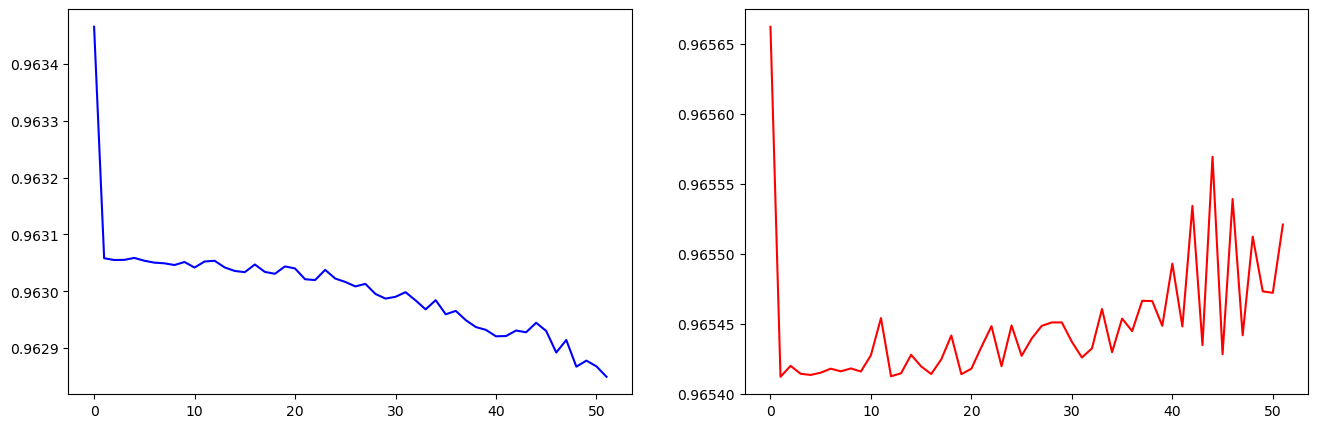

In [ ]:
train_loss_hist = []
val_loss_hist = []

iter_num = 0
EPOCHS = 100
BATCH_SIZE = 8192
LEARNING_RATE = 1e-3

mmf_cnn = MMFCNNTrain()
mmf_loss_fn = F.mse_loss
mmf_optimizer = torch.optim.Adam(mmf_cnn.parameters(),lr=LEARNING_RATE)

mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )

#assert torch.sum(mmf_cnn(xx)) > 0

for epoch in range(EPOCHS):
    mmf_train_batch_set = torch.utils.data.DataLoader(
        mmf_train_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
    )
    #mmf_optimizer = torch.optim.Adam(mmf_cnn.parameters(),lr=LEARNING_RATE*np.exp(-epoch/EPOCHS))
    for mmf_episode in mmf_train_batch_set:
        iter_num += 1

        predicted_targets = mmf_cnn(mmf_episode.features)

        train_loss = mmf_loss_fn(predicted_targets, mmf_episode.targets)

        mmf_cnn.zero_grad()
        train_loss.backward()
        mmf_optimizer.step()
        
        if not iter_num % 20:
            mmf_cnn.train(False)
            
            train_loss = mmf_loss_fn(mmf_cnn(features_dict), y_train_t)
            train_loss_hist.append(train_loss.item())
            
            val_loss = mmf_loss_fn(mmf_cnn(features_dict_val), y_val_t)
            val_loss_hist.append(val_loss.item())
            
            mmf_cnn.train(True)
            
            clear_output(True)

            tlh = pd.Series(train_loss_hist)
            vlh = pd.Series(val_loss_hist)

            fig,axs = plt.subplots(1,2,figsize=(16,5))
            axs[0].plot(tlh.index,tlh.values,label='train loss',color='blue')
            axs[1].plot(vlh.index,vlh.values,label='val loss',color='red')

            plt.show()